In [2]:
! python kmeans_anchors_ratios.py \
    --instances /home/mazheng/waste-detection/Yet-Another-EfficientDet-Pytorch-master/datasets/waste-detection/annotations/instances_train.json \
    --anchors-sizes 32 64 128 256 512 \
    --input-size 512 \
    --normalizes-bboxes True \
    --num-runs 3 \
    --num-anchors-ratios 3 \
    --max-iter 300 \
    --min-size 0 \
    --iou-threshold 0.5 \
    --decimals 1 \
    --default-anchors-ratios '[(0.7, 1.4), (1.0, 1.0), (1.4, 0.7)]'

[03/19 18:47:33] Reading /home/mazheng/waste-detection/Yet-Another-EfficientDet-Pytorch-master/datasets/waste-detection/annotations/instances_train.json
[03/19 18:47:33] Starting the calculation of the optimal anchors ratios
[03/19 18:47:33] Extracting and preprocessing bounding boxes
[03/19 18:47:33] Discarding 0 bounding boxes with size lower or equal to 0
[03/19 18:47:33] K-Means (3 runs): 100%|█████████████████| 3/3 [00:00<00:00, 290.48it/s]
	Runs avg. IoU: 88.05% ± 0.19% (mean ± std. dev. of 3 runs, 0 skipped)
	Avg. IoU between bboxes and their most similar anchors after norm. them to make their area equal (only ratios matter): 88.19%
[03/19 18:47:33] Default anchors ratios: [(0.7, 1.4), (1.0, 1.0), (1.4, 0.7)]
	Avg. IoU between bboxes and their most similar default anchors, no norm. (both ratios and sizes matter): 8.43%
	Num. bboxes without similar default anchors (IoU < 0.5):  147/149 (98.66%)
[03/19 18:47:33] K-Means anchors ratios: [(1.2, 0.8), (1.5, 0.7), (1.8, 0.6)]
	Avg. Io

/home/mazheng/miniconda3/envs/eff/lib/python3.7/site-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


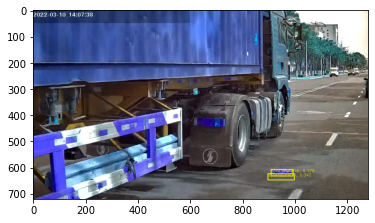

In [11]:
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess

compound_coef = 2
force_input_size = None  # set None to use default size
img_path = '/home/mazheng/waste-detection/Yet-Another-EfficientDet-Pytorch-master/datasets/waste-detection/val/952.jpg'

threshold = 0.04
iou_threshold = 0.2

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True


obj_list = ["spiledmaterial"]

# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                             # replace this part with your project's anchor config
                             ratios=[(1.2, 0.8), (1.5, 0.7), (1.8, 0.6)],
                             scales=[2 ** 0/4, 2 ** (1.0 / 3.0)/4, 2 ** (2.0 / 3.0)/4])

model.load_state_dict(torch.load('weights/waste-detection/efficientdet-d2_90_1000.pth'))
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

with torch.no_grad():
    features, regression, classification, anchors = model(x)

    # print(classification)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x,
                      anchors, regression, classification,
                      regressBoxes, clipBoxes,
                      threshold, iou_threshold)
# print(out)
# print(x.shape[0])
out = invert_affine(framed_metas, out)

# print(out)

for i in range(len(ori_imgs)):
    if len(out[i]['rois']) == 0:
        # print(len(ori_imgs))
        continue
    ori_imgs[i] = ori_imgs[i].copy()
    for j in range(len(out[i]['rois'])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
        cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])

        cv2.putText(ori_imgs[i], '{}, {:.3f}'.format(obj, score),
                    (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 0), 1)

        plt.imshow(ori_imgs[i])

using weights logs/waste-detection/efficientdet-d0_45_500.pth


'logs/waste-detection/efficientdet-d0_45_500.pth'